# Update existing Sfincs model with boundary conditions and forcing

This notebook demonstrates how to update an existing SFINCS model with gauges, boundary conditions and forcing such as precipitation. The notebook does not contain the SFINCS code or executables to run the model with. 

We will perform the following:
* append an existing schematization that only contains static schematization layers
* introduce gridded precipitation only 
* introduce gridded precipitation, water level boundaries and observation gauge point locations
* write the new models to new model folders


### HydroMT CLI build interface
First let us check if HydroMT has the Sfincs plugin available. The result of the code block below should be
`hydroMT model plugins: sfincs (vx.x.x)` where `x.x.x` denotes the current version (e.g. `0.1.0`). If Sfincs seems missing, ensure it is installed by typing `pip install hydromt_sfincs` on a command line.

In [7]:
!hydromt --models

hydroMT model plugins: sfincs (v0.1.0)


### Add precipitation forcing to an existing model
Rather than rebuilding a model from scratch, we can add or update components to an existing model. You may want to update several things at the same time. This may be useful, for instance when you are considering model intercomparisons, with different parameter sets or underlying static maps, or comparing the impact of different forcing datasets. 

This is possible by preparing a **configuration file** that includes every components and settings that you want to do during your update.

The ini-file contains the model setup configuration and determines which components are updated and in which sequence and sets optional arguments for each component. This configuration is passed to hydromt using `-i <path_to_ini_file>`.

Each header as shown between `[...]` (e.g. `[setup_precip_forcing]`) corresponds with a model component which are explained in the [docs(model_components)](https://deltares.github.io/hydromt_sfincs/latest/user_guide/sfincs/components.html).

Let's open the example configuration file **sfincs_update_precip.ini** from the model repository [examples folder] and have a look at the settings.

In [8]:
fn_ini = 'sfincs_update_precip.ini'
with open(fn_ini, 'r') as f:
    txt = f.read()
print(txt)

[setup_config]
tref = 20100101 000000
tstart = 20100201 000000
tstop = 20100210 000000

[setup_p_forcing_gridded]
precip_fn = era5_hourly         # gridded precipitation data ['precip']
dst_res = None                  # output resolution (m)



Two components are to be updated:
* **setup_config**: This section directly overwrites parts of the .inp configuration file. You can extend this with any settings of the .inp file. The time settings need to be altered. We have made sure that the time coverage is available in the precipitation sample dataset. 
* **setup_p_forcing_gridded**: here, we identify which dataset, available in our data catalog is to be used as forcing. The dataset **era5_hourly** has to be represented in the **data_catalog.yml**. Please check your **$HOME/.hydromt_data** folder to see if it is indeed present. If it is, then you can continue below to add the forcing. 

We need the `update` command of hydromt to update the model with this .ini file. Let's get an overview of the options.

In [9]:
!hydromt update --help

Usage: hydromt update [OPTIONS] MODEL MODEL_ROOT

  Update a specific component of a model. Set an output directory to copy
  the edited model to a new folder, otherwise maps are overwritten.

  Example usage:
  --------------

  Update (overwrite) landuse-landcover maps in a wflow model
  hydromt update wflow /path/to/model_root -c setup_lulcmaps --opt source_name=vito

  Update reservoir maps based on default settings in a wflow model and write to new directory
  hydromt update wflow /path/to/model_root -o /path/to/model_out -c setup_reservoirs

Options:
  -o, --model-out DIRECTORY  Output model folder. Maps in MODEL_ROOT are
                             overwritten if left empty.

  -c, --components TEXT      Model components from ini file to run
  --opt TEXT                 Component specific keyword arguments, see the
                             setup_<component> method of the specific model
                             for more information about the arguments.

  -i, --config PA

### Update sfincs precipitation
Now we will add the precipitation and write the model to a new folder

In [11]:
!hydromt update sfincs ./venice -o ./venice_sfincs_precip -i sfincs_update_precip.ini -v

2021-05-11 14:07:59,676 - update - log - INFO - HydroMT version: 0.4.1.dev
2021-05-11 14:07:59,676 - update - main - INFO - Updating sfincs model at /home/hcwinsemius/git/hydromt_sfincs/examples/venice (r).
2021-05-11 14:07:59,676 - update - main - INFO - Output dir: /home/hcwinsemius/git/hydromt_sfincs/examples/venice_sfincs_precip
2021-05-11 14:07:59,676 - update - main - INFO - User settings:
2021-05-11 14:07:59,717 - update - cli_utils - INFO - setup_config.tref: 20100101 000000
2021-05-11 14:07:59,717 - update - cli_utils - INFO - setup_config.tstart: 20100201 000000
2021-05-11 14:07:59,717 - update - cli_utils - INFO - setup_config.tstop: 20100210 000000
2021-05-11 14:07:59,717 - update - cli_utils - INFO - setup_p_forcing_gridded.precip_fn: era5_hourly
2021-05-11 14:07:59,717 - update - cli_utils - INFO - setup_p_forcing_gridded.dst_res: None
2021-05-11 14:07:59,717 - update - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.1.0).
2021-05-11 14:07:59,813 - up

The example above means the following: run **hydromt** with:

- `update sfincs`: i.e. update a sfincs model
- `./venice_sfincs`: original model folder
- `-o ./venice_sfincs_precip`: output updated model folder
- `-i sfincs_update_precip.ini`: setup configuration file containing the components to update and their different options
- `v`: give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.


Let's inspect the new model folder

In [12]:
ls ./venice_sfincs_precip/

gis/         precip.nc   sfincs.bzs  sfincs.ind  sfincs.man  sfincs.scs
hydromt.log  sfincs.bnd  sfincs.dep  sfincs.inp  sfincs.msk


We now have a .nc file with the precipitation. The .inp file now also contains a reference to this dataset.

### Inspect forcing data

The forcing data will also be available for analysis and plotting within hydromt. The `plot_forcing` method plots the area averaged precipitation. If you are familiar with xarray and matplotlib, it is straighforward to make some other plots as well.

In [13]:
%matplotlib inline
import hydromt
import matplotlib.pyplot as plt

Below, we first plot the area averaged time series

(<Figure size 432x216 with 1 Axes>,
 [<AxesSubplot:title={'center':'SFINCS precipitation boundaries (netampr)'}, xlabel='time', ylabel='precipitation [mm.hr-1]'>])

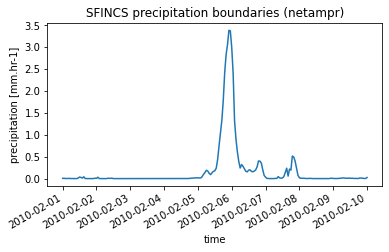

In [14]:
mod = hydromt.SfincsModel(root="venice_sfincs_precip", mode="r")
mod.plot_forcing()

We can also manipulate the forcing and make spatial plots with xarray logic. Below we plot the time accumulated rainfall over the entire period.

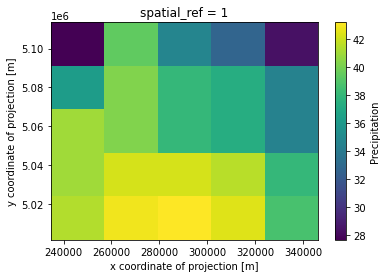

In [15]:
# precipitation forcing is in the key "netampr"
precip_sum = mod.forcing["netampr"].sum(dim="time")
precip_sum.plot()

We have another .ini file that also includes water level boundaries from the Global Tide and Surge Model, and also includes several measurement locations (`setup_gauges`). Below we print the contents of this .ini file and the gauges file.

In [16]:
fn_ini = 'sfincs_update_forcing.ini'
with open(fn_ini, 'r') as f:
    txt = f.read()
print("=========")
print(".ini file")
print("=========")
print(txt)

import pandas as pd
fn_gauges = 'venice_gauges.csv'
df = pd.read_csv(fn_gauges)
print("=================================")
print("gauges file (as pandas DataFrame)")
print("=================================")
df


.ini file
[setup_config]
tref = 20100101 000000
tstart = 20100201 000000
tstop = 20100210 000000

[setup_gauges]
gauges_fn = venice_gauges.csv   # gauges point locations
crs = 4326

[setup_h_forcing]
gauges_fn = gtsmv3_eu_era5      # waterlevel gauge data
timeseries_fn = None            # timeseries data at waterlevel gauges
mdt_fn = dtu10mdt_egm96         # mean dynamic topography ['mdt']
buffer = 1e4                    # buffer around model region to select gauges

[setup_p_forcing_gridded]
precip_fn = era5_hourly         # gridded precipitation data ['precip']
dst_res = None                  # output resolution (m)

gauges file (as pandas DataFrame)


,ID,Name,x,y
0,1001,Venice1,12.513886,45.508725
1,1002,Venice2,12.443603,45.495637
2,1003,Venice3,12.347785,45.423504
3,1004,Venice4,12.312603,45.443641


You can see a few things:
* the water level forcing configured under `setup_h_forcing` refers to a dataset from the catalog. Check the .yml of the catalog (see folder `$HOME/.hydromt_data` for further details)
* the file `venice_gauges.csv` has a very simple setup with latitude/longitude coordinate pairs

Now let's build another version of the model that includes these new inputs

In [19]:
!hydromt update sfincs ./venice -o ./venice_sfincs_forcing -i sfincs_update_forcing.ini -v

2021-05-11 14:08:57,004 - update - log - INFO - HydroMT version: 0.4.1.dev
2021-05-11 14:08:57,004 - update - main - INFO - Updating sfincs model at /home/hcwinsemius/git/hydromt_sfincs/examples/venice (r).
2021-05-11 14:08:57,005 - update - main - INFO - Output dir: /home/hcwinsemius/git/hydromt_sfincs/examples/venice_sfincs_forcing
2021-05-11 14:08:57,005 - update - main - INFO - User settings:
2021-05-11 14:08:57,043 - update - cli_utils - INFO - setup_config.tref: 20100101 000000
2021-05-11 14:08:57,043 - update - cli_utils - INFO - setup_config.tstart: 20100201 000000
2021-05-11 14:08:57,043 - update - cli_utils - INFO - setup_config.tstop: 20100210 000000
2021-05-11 14:08:57,043 - update - cli_utils - INFO - setup_gauges.gauges_fn: /home/hcwinsemius/git/hydromt_sfincs/examples/venice_gauges.csv
2021-05-11 14:08:57,043 - update - cli_utils - INFO - setup_gauges.crs: 4326
2021-05-11 14:08:57,043 - update - cli_utils - INFO - setup_h_forcing.gauges_fn: gtsmv3_eu_era5
2021-05-11 14:0

We can now again inspect the model

/home/hcwinsemius/git/hydromt_sfincs/examples/venice_sfincs_forcing/sfincs.inp


(<Figure size 864x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'SFINCS dep map'}, xlabel='x coordinate UTM zone 33N [m]', ylabel='y coordinate UTM zone 33N [m]'>)

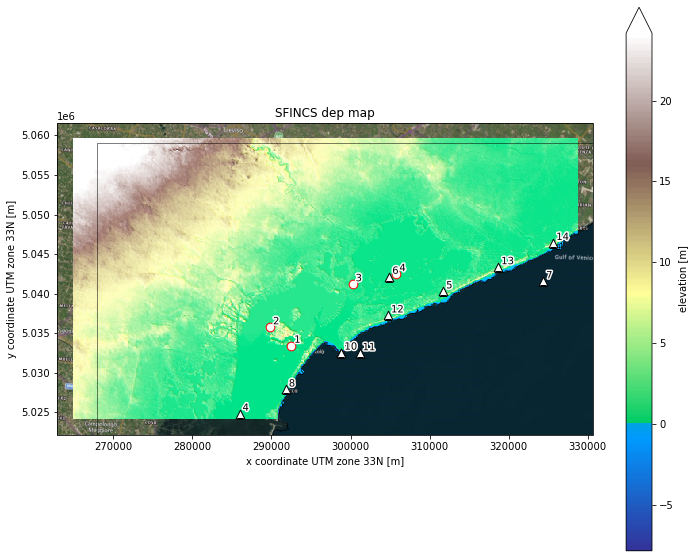

In [20]:
# define the model's configuration file
import os
import hydromt
root = r'./venice_sfincs_forcing'
config_fn = os.path.abspath(os.path.join(root, 'sfincs.inp'))
print(config_fn)
# read the model with hydromt sfincs methods
mod = hydromt.SfincsModel(root=root, config_fn=config_fn, mode="r")
mod.read()
mod.plot_basemap(figsize=(12, 10))

We also have some new forcing, the tidal boundary conditions from gtsm. Below we also inspect these

(<Figure size 432x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'SFINCS waterlevel boundaries (bzs)'}, xlabel='time', ylabel='waterlevel [m+EGM96]'>,
        <AxesSubplot:title={'center':'SFINCS precipitation boundaries (netampr)'}, xlabel='time', ylabel='precipitation [mm.hr-1]'>],
       dtype=object))

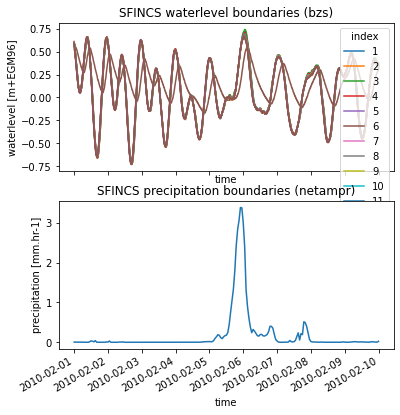

In [21]:
mod.plot_forcing()

Important files are:
* .inp file : holds the model's configuration
* .dep file : holds the bathymetry in the typical format of sfincs
* .msk file : mask file (0, inactive cells, 1, active cells, 2, boundary cells)
* .obs file : holds the points (x, y) where observation locations are present (taken from geojson file in .ini)
* .src file : same as .obs but for discharge inflow locations
* .dis file : discharge time series, same number of columns as the discharge locations
* .bnd file : same as .obs but for locations with water level boundary conditions
* .bzs file : same as .dis but for time series of water level boundary conditions
* The .log file holds logging information of hydromt. Inspect it to see if everything went as supposed.

Now we will use hydromt methods to read the model back in memory and inspect it with typical pythonic methods (xarray, geopandas and so on)